In [67]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Estimated shares outstanding

In [68]:
## Read data
data = pd.read_csv("stock_data.csv")

In [69]:
data.head()

,Unnamed: 0,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


In [70]:
## Check for nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1781 entries, 0 to 1780
Data columns (total 79 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1781 non-null   int64  
 1   Ticker Symbol                                        1781 non-null   object 
 2   Period Ending                                        1781 non-null   object 
 3   Accounts Payable                                     1781 non-null   float64
 4   Accounts Receivable                                  1781 non-null   float64
 5   Add'l income/expense items                           1781 non-null   float64
 6   After Tax ROE                                        1781 non-null   float64
 7   Capital Expenditures                                 1781 non-null   float64
 8   Capital Surplus                                      1781 non-null  

In [71]:
## Drop columns as instructed
cols_to_drop = ['Unnamed: 0', 'Ticker Symbol', 'Period Ending', 'For Year']

df = data.loc[:, ~data.columns.isin(cols_to_drop)]

## Drop rows where Estimated Shares Outstanding is null. This is because we are predicting Estimated Shares Outstanding

df = df.loc[~df['Estimated Shares Outstanding'].isna(),:]
for i in df.columns:
    if df[i].isna().sum() !=0:
        print(i, df[i].isna().sum()*100/len(df[i]))
## We observe that 3 columns contain ~17% nulls

## Check model with and without imputation

## Dropping all NAs
df0 = df.dropna() ## Dropping all NAs will not effect the dataset as much as the number of data points being dropped does not affect the p/n ratio significantly

## Mutliple imputation for missing values

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

df1 = df
cols = df1.columns

imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(df1)
df_1 = imp.transform(df1)

df1 = pd.DataFrame(df_1, columns = cols)

## Random forest is not affected by multicollinearity and hence, there is not need to remove highly correlated variables

Cash Ratio 16.837387964148526
Current Ratio 16.837387964148526
Quick Ratio 16.837387964148526


#### Random forest with default hyperparameters

In [72]:
from sklearn.ensemble import RandomForestRegressor ## Because our dependant variable is continuous
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


## No imputation

y0 = df0['Estimated Shares Outstanding']/1000000  ## MSE is affected by the magnitude of y, so taking y in $ millions for ease of MSE comparision across models

X0 = df0.drop('Estimated Shares Outstanding', axis = 1)

X_train0, X_test0, y_train0, y_test0 = train_test_split(X0, y0, test_size = 0.3, random_state = 42)

clf = RandomForestRegressor(random_state=0)
clf.fit(X_train0, y_train0)

y_pred0 = clf.predict(X_test0)

print(f"OOS MSE for data without imputation: {mean_squared_error(y_test0, y_pred0)}")

## Imputed data

y1 = df1['Estimated Shares Outstanding']/1000000  ## MSE is affected by the magnitude of y, so taking y in $ millions for ease of MSE comparision across models

X1 = df1.drop('Estimated Shares Outstanding', axis = 1)

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.3, random_state = 42)

clf = RandomForestRegressor(random_state=0)
clf.fit(X_train1, y_train1)

y_pred1 = clf.predict(X_test1)

print(f"OOS MSE for data with imputation: {mean_squared_error(y_test1, y_pred1)}")

OOS MSE for data without imputation: 81825.68467182704
OOS MSE for data with imputation: 76945.99426773697


#### Random forest with min_samples_split = 3

In [73]:
## Data with imputation has a lower OOS MSE. Hence, retainig data with imputed values

clf_1 = RandomForestRegressor(min_samples_split = 3, random_state=0) ## Random forest with min_samples_split = 3
clf_1.fit(X_train1, y_train1)

y_pred_1 = clf_1.predict(X_test1)

print(f"OOS MSE for min_samples_split = 3: {mean_squared_error(y_test1, y_pred_1)}")

## It can be observed that the MSE increases when the min_samples_split is set to 3
## This could mean that the model with min_samples_split = 3 is underfitted and cannot capture the complex pattern in the underlying data
## This has to do with the bias variance tradeoff for the model. While more splits would ensure generalizability, and hence reduced variance,
## depending on the nature/complexity of the data, it may be a litte too generalized leading to undefitting hence higher bias

OOS MSE for min_samples_split = 3: 84893.20094061091


#### Mean Decrease in Impurity and Permutation Feature Importance for variable importance in clf_1

MDI feature importances: 

Accounts Payable: 0.0107
Accounts Receivable: 0.0013
Add'l income/expense items: 0.0013
After Tax ROE: 0.0047
Capital Expenditures: 0.0009
Capital Surplus: 0.0252
Cash Ratio: 0.0026
Cash and Cash Equivalents: 0.0012
Changes in Inventories: 0.0012
Common Stocks: 0.1234
Cost of Revenue: 0.0009
Current Ratio: 0.0017
Deferred Asset Charges: 0.0100
Deferred Liability Charges: 0.0009
Depreciation: 0.0019
Earnings Before Interest and Tax: 0.1895
Earnings Before Tax: 0.0571
Effect of Exchange Rate: 0.0028
Equity Earnings/Loss Unconsolidated Subsidiary: 0.0027
Fixed Assets: 0.0022
Goodwill: 0.0053
Gross Margin: 0.0024
Gross Profit: 0.0050
Income Tax: 0.0015
Intangible Assets: 0.0020
Interest Expense: 0.0023
Inventory: 0.0009
Investments: 0.0013
Liabilities: 0.0030
Long-Term Debt: 0.0033
Long-Term Investments: 0.0011
Minority Interest: 0.0082
Misc. Stocks: 0.0006
Net Borrowings: 0.0013
Net Cash Flow: 0.0016
Net Cash Flow-Operating: 0.0387
Net Cash Flows-Financing: 0.00

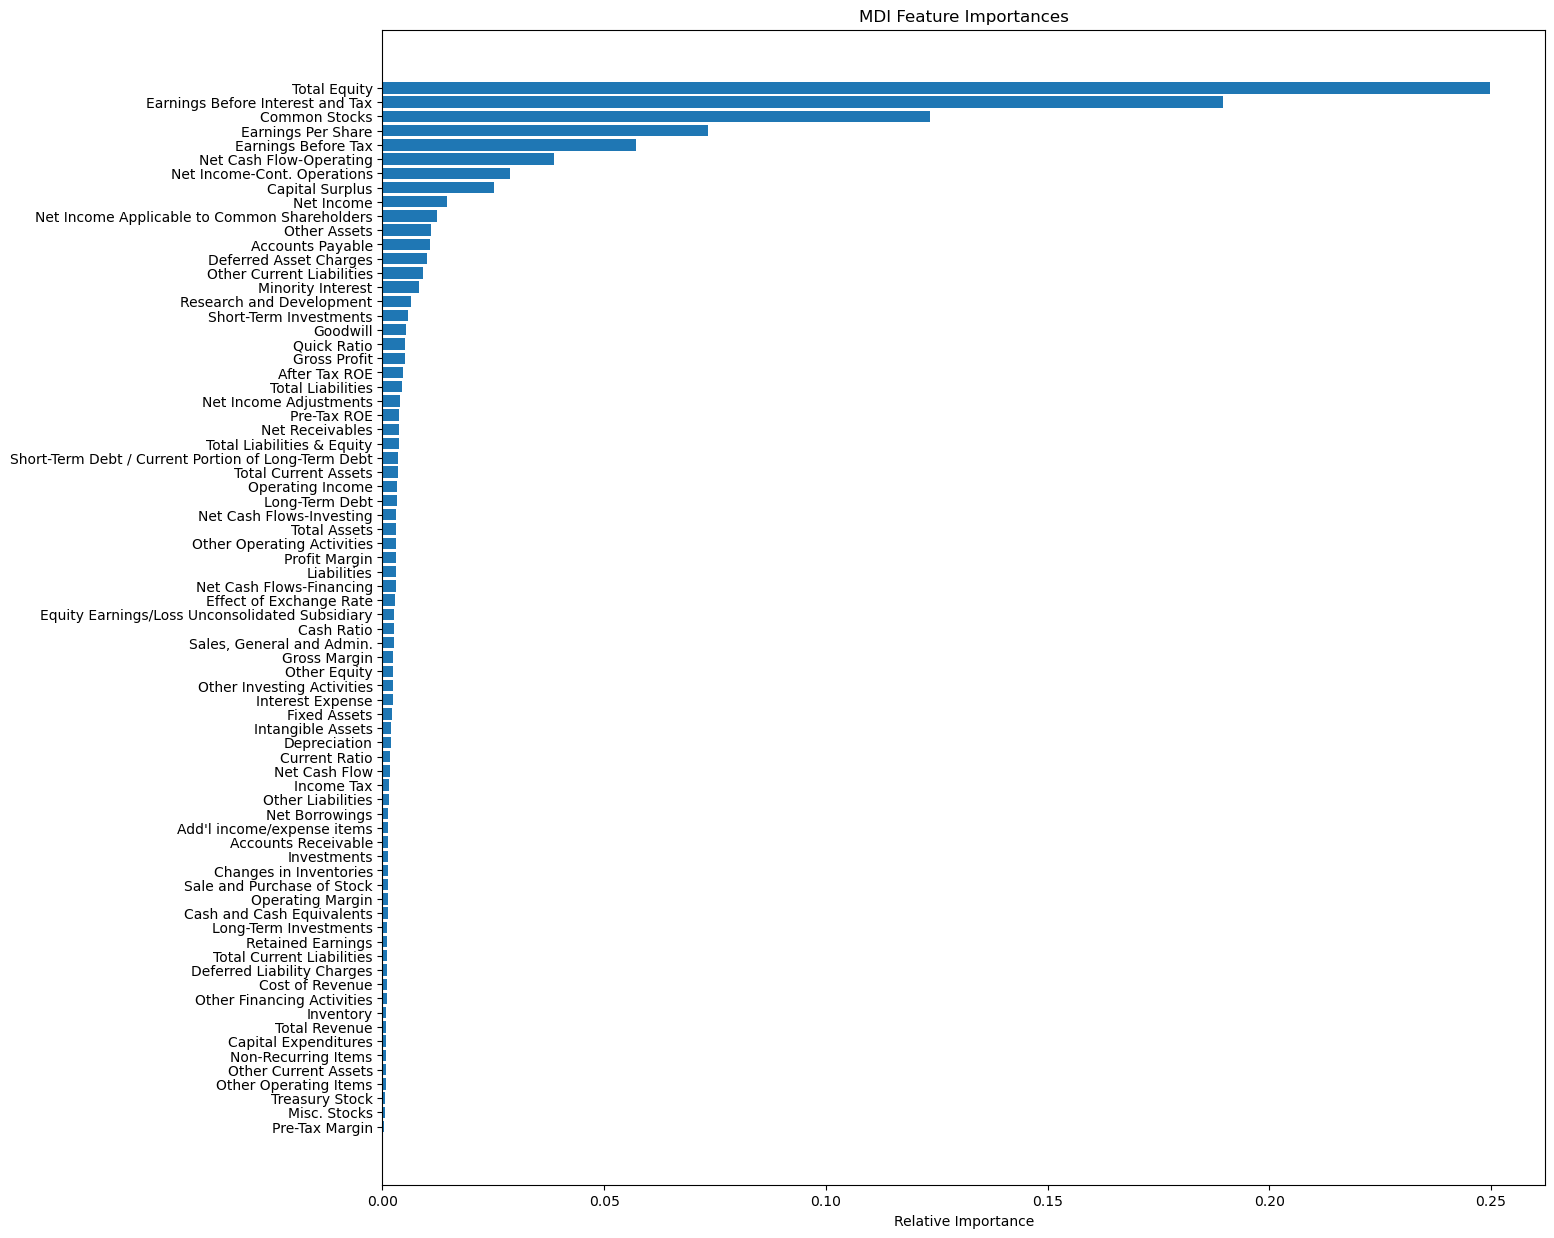

In [74]:
## Default random forest in sklearn uses MDI/ Gini importance for feature importance. 

## Mean Decrease in Impurity (MDI) calculates each feature importance as the sum over the number of splits (across all tress) 
## that include the feature, proportionally to the number of samples it splits.

## But as given in sklearn random forest documentation,
## Impurity-based feature importance for trees are strongly biased and favor high cardinality features 
## (typically numerical features) over low cardinality features such as binary features or 
## categorical variables with a small number of possible categories

## MDI for feature importance

MDI_imp = clf_1.feature_importances_

print("MDI feature importances: \n")
for i, feat in enumerate(X1.columns):
    print(f"{feat}: {MDI_imp[i]:.4f}")

indices = np.argsort(MDI_imp)
plt.figure(figsize = (15,15))
plt.barh(range(len(indices)), MDI_imp[indices], align='center')
plt.yticks(range(len(indices)), [X1.columns[i] for i in indices])
plt.xlabel('Relative Importance')
plt.title('MDI Feature Importances')
plt.show()

In [75]:
## Permutation Feature Importance 
import time

## Notes on Permutation Feature Importance

## Done by OOB random shuffle one feature at a time for all features. 
## When the nth tree is grown, the OOB samples are passed down the tree, and the prediction accuracy is recorded. 
## Then the values for the jth variable are randomly permuted in the OOB samples, and the accuracy is again computed. 
## The decrease in accuracy as a result of this permuting is averaged over all trees, and is used as a measure of the importance of variable j in the random forest

## It is a very generalizable method to glean feature importances.
## Downsides, computationaly expensive and overestimation of importances for correlated predictors

from sklearn.inspection import permutation_importance

start_time = time.time()

PFI_imp = permutation_importance(clf_1, X_test1, y_test1, n_repeats = 10, random_state = 2)

print(f"Time for execution: {time.time() - start_time}s")
print("\n")

print("Permutation feature importances for random forest model: \n")
for i, feat in enumerate(X1.columns):
    print(f"{feat}: {PFI_imp.importances_mean[i]:.4f} +/- {PFI_imp.importances_std[i]:.4f}")


Time for execution: 9.325103044509888s


Permutation feature importances for random forest model: 

Accounts Payable: -0.0086 +/- 0.0007
Accounts Receivable: 0.0002 +/- 0.0001
Add'l income/expense items: 0.0000 +/- 0.0001
After Tax ROE: -0.0004 +/- 0.0006
Capital Expenditures: 0.0004 +/- 0.0002
Capital Surplus: 0.0225 +/- 0.0052
Cash Ratio: -0.0026 +/- 0.0002
Cash and Cash Equivalents: 0.0005 +/- 0.0002
Changes in Inventories: 0.0001 +/- 0.0001
Common Stocks: 0.0317 +/- 0.0061
Cost of Revenue: 0.0013 +/- 0.0002
Current Ratio: 0.0017 +/- 0.0004
Deferred Asset Charges: 0.0018 +/- 0.0006
Deferred Liability Charges: 0.0007 +/- 0.0001
Depreciation: 0.0004 +/- 0.0001
Earnings Before Interest and Tax: 0.1083 +/- 0.0071
Earnings Before Tax: 0.0221 +/- 0.0024
Effect of Exchange Rate: 0.0023 +/- 0.0007
Equity Earnings/Loss Unconsolidated Subsidiary: 0.0008 +/- 0.0002
Fixed Assets: 0.0001 +/- 0.0002
Goodwill: 0.0035 +/- 0.0009
Gross Margin: -0.0003 +/- 0.0003
Gross Profit: 0.0021 +/- 0.0005
Incom

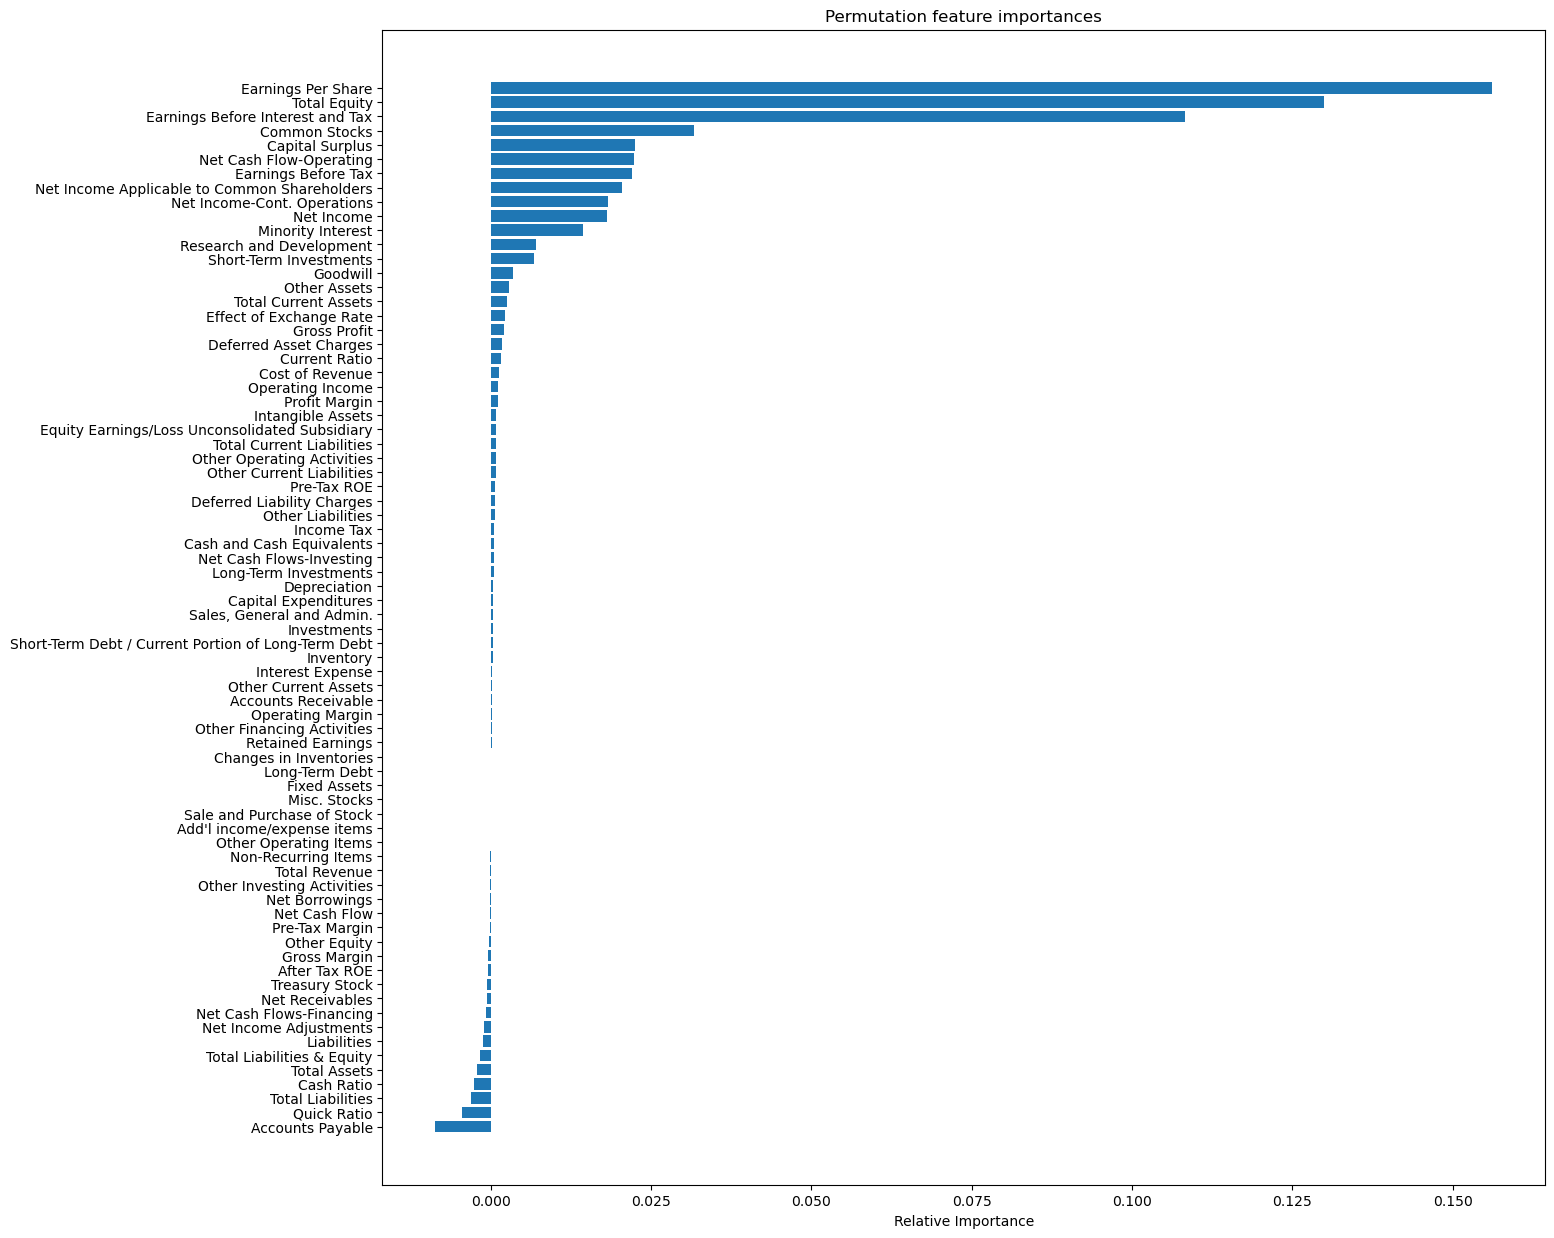

In [76]:
plt.figure(figsize = (15,15))
plt.barh(y = X1.columns[np.argsort(PFI_imp.importances_mean)], width = np.sort(PFI_imp.importances_mean))
plt.xlabel('Relative Importance')
plt.title('Permutation feature importances')
plt.show()

## Negetive values on the plot indicate features that the model would be better off without.

In this case, we can see that PFI suggests that there are some variables which has no importance or -ve importance implying that these features are not needed or even decrease model performance. It could also indicate redundance features. Effectively, PFI does a variable selection for us.

While, MDI retains variable importance for all features.

In this case, it would be better to use PFI since we are aware that the dataset contains many redundant features which may not be revelant to the model, or are highly correlated

#### Lasso

Lasso OOS MSE: 202240.95535560427


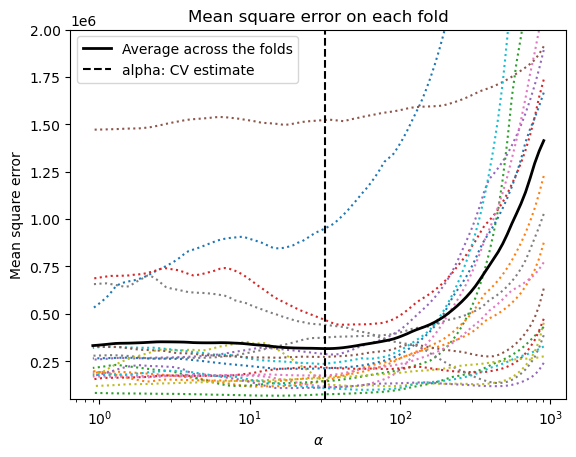

In [77]:
from sklearn.linear_model import LassoCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), LassoCV(cv = 20, max_iter = 10000)).fit(X_train1, y_train1)

ymin, ymax = 50000, 2000000
lasso = model[-1]
plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold"
)

best_alpha = model.named_steps['lassocv'].alpha_ ## Get best lambda value

## Fit lasso model
from sklearn.linear_model import Lasso

lasso_model = make_pipeline(StandardScaler(), Lasso(alpha = best_alpha)).fit(X_train1, y_train1)
y_pred_lasso = lasso_model.predict(X_test1)

mse = mean_squared_error(y_test1, y_pred_lasso)
print(f"Lasso OOS MSE: {mse}")

## It can be observed that the best Lasso model's MSE is much higher than that of the random forest model

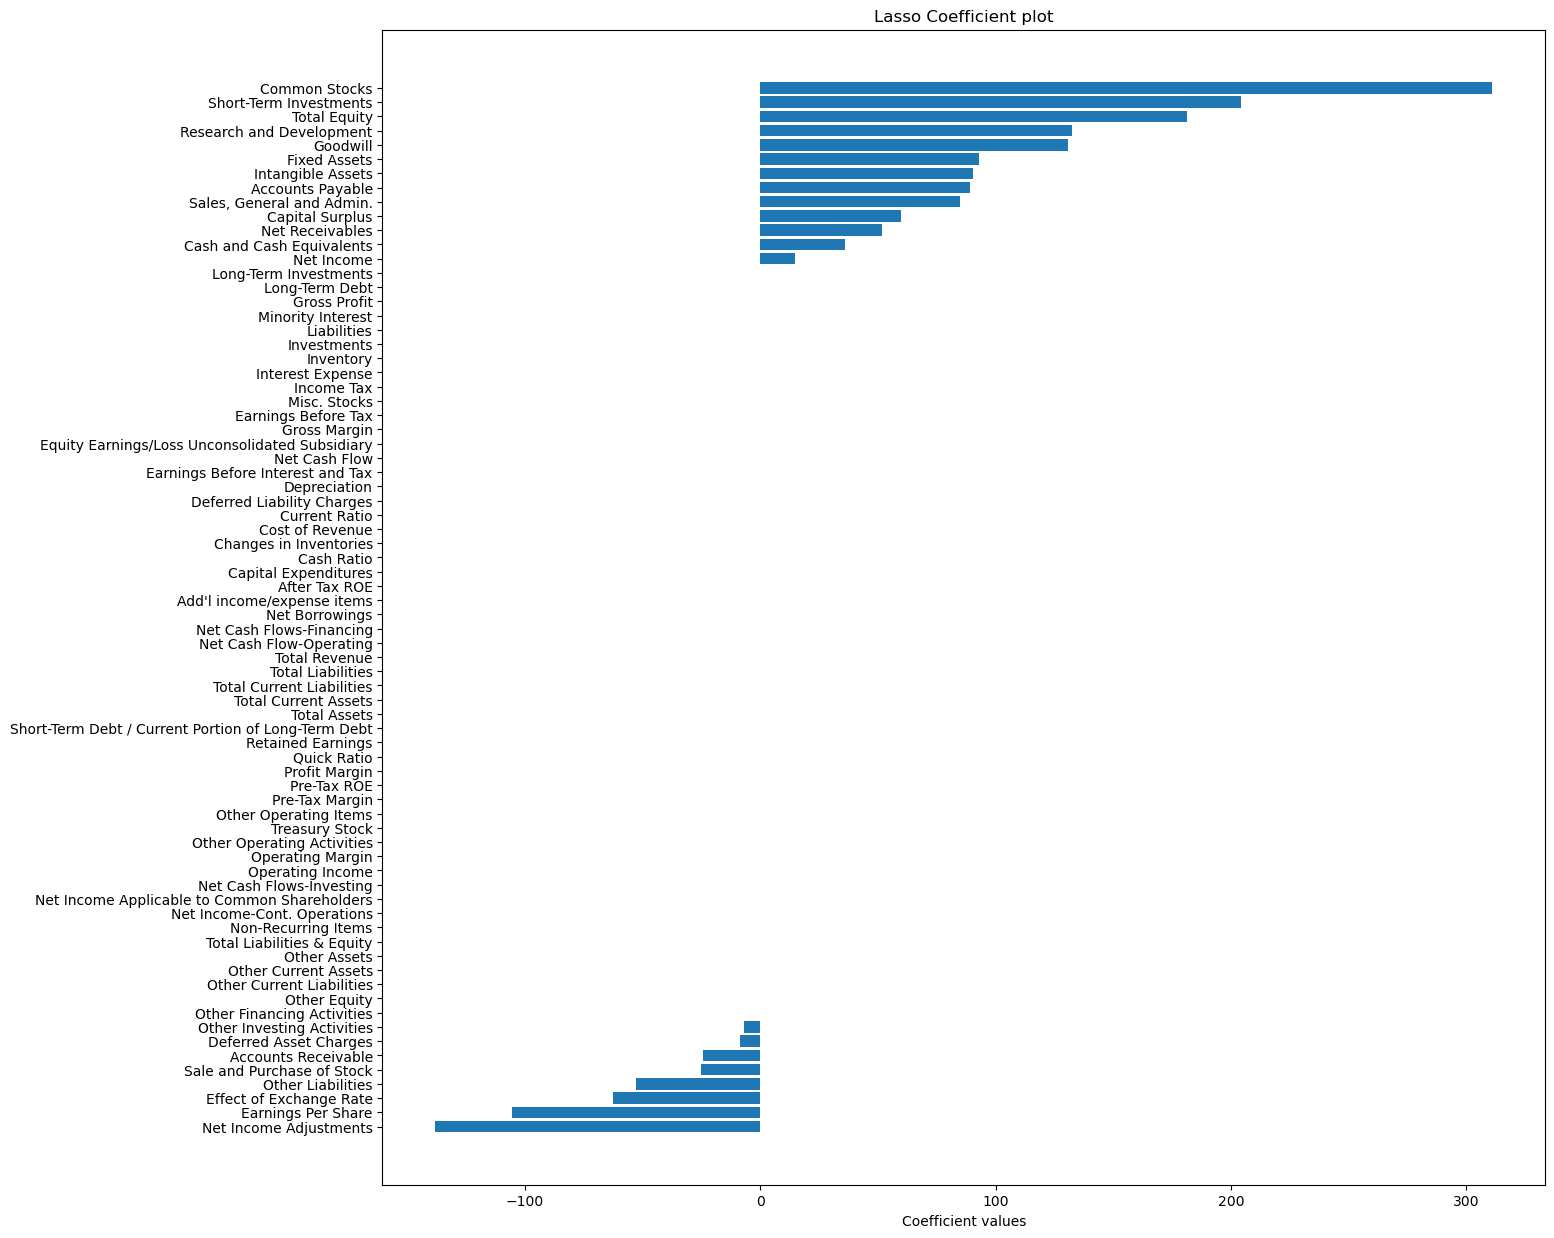

In [78]:
lasso = lasso_model.named_steps['lasso']
lasso.coef_

plt.figure(figsize = (15,15))
plt.barh(y = X1.columns[np.argsort(lasso.coef_)], width = np.sort(lasso.coef_))
plt.xlabel('Coefficient values')
plt.title('Lasso Coefficient plot')
plt.show()

##### Notes on Lasso
- Lasso model's OOS performance is not as great compared to the Random forest model. We can see that Lasso model rids the model of a lot of variables compared to the variables obtained from PFI model. 
- Lasso could potentially be underfitting in this case

## 2. Cancer dataset

In [79]:
data = pd.read_csv("breast_cancer.csv")

In [80]:
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [81]:
data = data.drop(['Unnamed: 32', 'id'], axis = 1)

In [82]:
data.info()
## No nulls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se                  5

#### Train and test data split and Decision Tree model training

In [83]:
from sklearn import tree

y = data['diagnosis']
X = data.iloc[:, ~data.columns.isin(['diagnosis'])]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

clf = tree.DecisionTreeClassifier().fit(X_train, y_train)

y_pred = clf.predict(X_test)

#### Confusion matrix to evaluate model

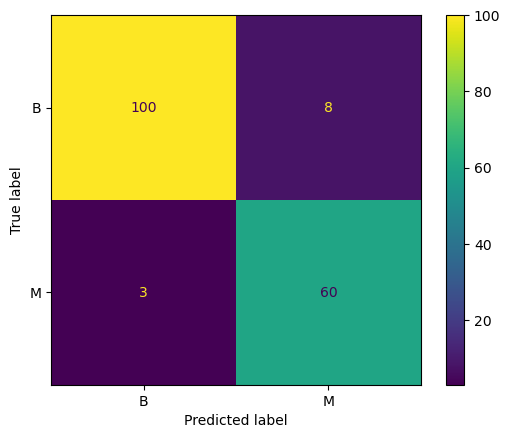

In [84]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

##### Explaination of confusion matrix

- From the confusion matrix, we can observe that the model wrongly predicted the tumor as benign 4 times, when it was actually a malignant tumor. On the other hand, it predicts the tumor as benign 7 times when actually the tumor was malignant.
- From this we can find that accuracy = (101+59)/171 = 93.5%
- Recall (assuming malignant as positive) = 89.3% We need this to be high as predicting the malignant tumour correctly is extremely important

#### Decision tree classifier visualization

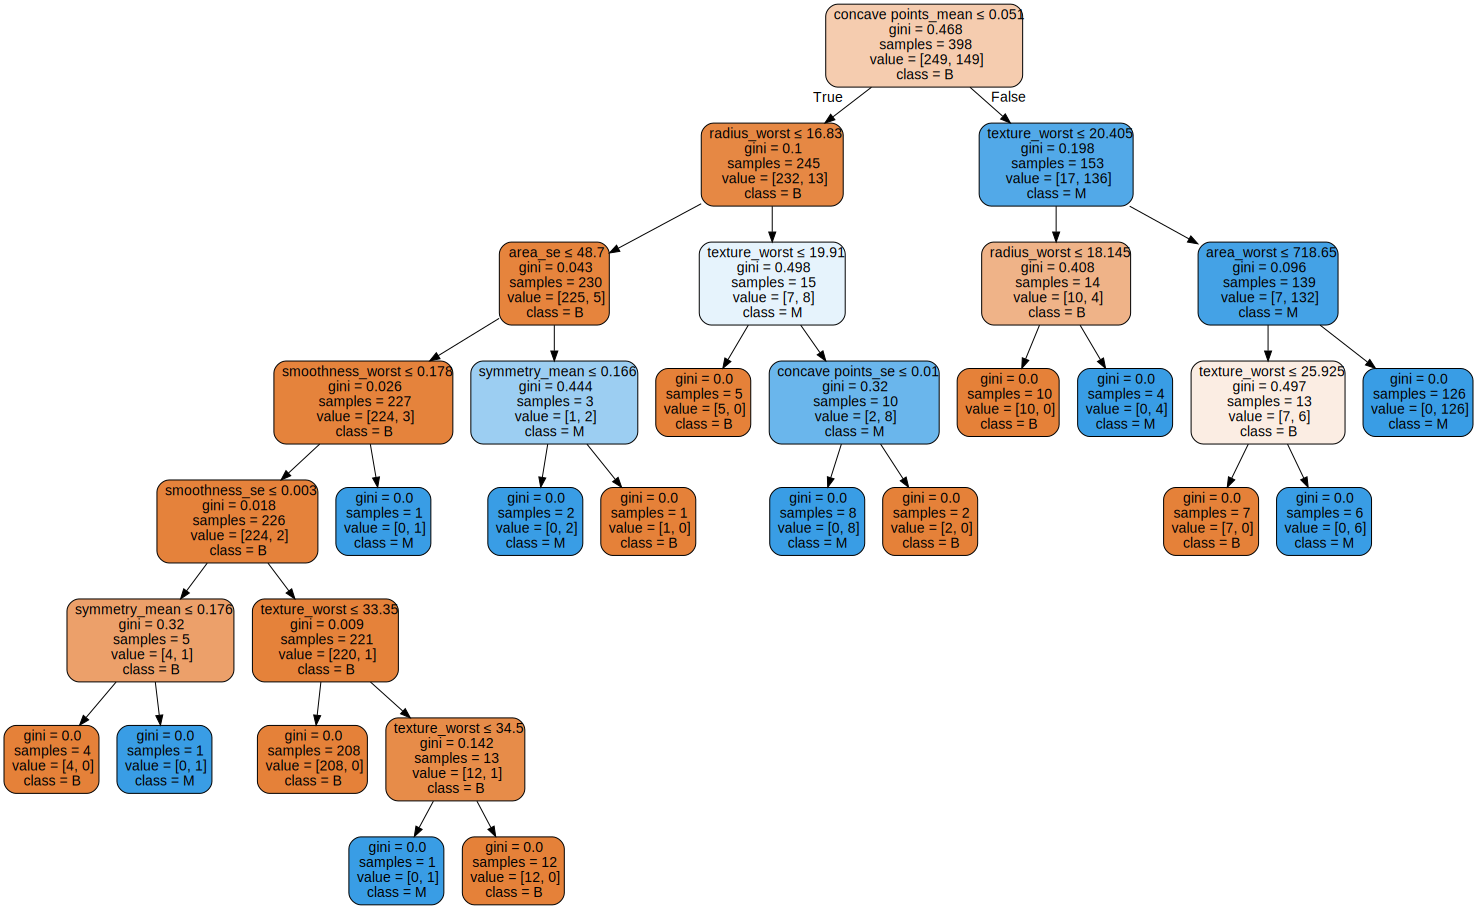

In [85]:
## Visualize the decision tree
import graphviz

y = pd.Categorical(y)
class_names = y.categories
    
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names = X.columns, 
                                class_names = class_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

## Varibales in the tree
## concave points_mean, radius_worst, texture_worst, area_worst, perimeter_worst, texture_mean, fractal_dimension_worst,
## radius_se, concave points_mean, smoothness_worst, smoothness_se, concavity_worst

##### Notes on pruning considerations

- Yes, I would consider prunig the tree.
- The tree is clearly overfitting on the left side
- Potential points where this can be observed
  1. Splits are being made on small samples (texture_worst ≤ 34.5 where n = 13), (concavity_worst ≤ 0.195 n = 5) when the node is very deep
  2. we can observe that after smoothness_se ≤ 0.003 the color is not changing much 
- To prune the tree, I will be considering,
  1. The gini score
  2. Sample size at the node where the split is being made
  3. Color of the nodes and leaves to check if the split is actually making any reliable distinction between categories